# Demo Camera OV7670
- Source : https://github.com/m-dilorenzi/OV7670-PynqZ2
- Upload `Overlay/antminerOV7670` into Antminer S9 via SFTP into folder `/home/xilinx/pynq/overlays/`<br><br>

<img src="resource/OV7670 wiring.jpg" width="900px">

In [1]:
from pynq import Overlay, MMIO, lib
from pynq.lib.video import VideoMode
from pynq.lib import AxiGPIO
from pynq.lib.iic import AxiIIC
from PIL import Image
import cffi
from time import sleep

<font color="orange"> ⚠️⚠️⚠️ Before starting this piece of code be sure that `STARTUP` pin is in `OFF` position ⚠️⚠️⚠️</font>

In [2]:
overlay = Overlay("antminerOV7670.bit")

In [3]:
i2c = AxiIIC(overlay.ip_dict['axi_iic'])

# soft reset I2C
XIIC_RESETR_OFFSET = 0x40
XIIC_RESET_MASK = 0x0000000A

i2c.write(XIIC_RESETR_OFFSET, XIIC_RESET_MASK)

In [4]:
for address in range(0x00, 0x77):
    try:
        # Attempt to read 1 byte from the current address
        i2c.send(address, [0x00], 1)
        print(f"Found I2C device at address: 0x{address:02X}")
    except Exception:
        # No response from the current address
        pass

Found I2C device at address: 0x21


In [5]:
# Class to manage the convolution filter mapped on FPGA. It provides method to modify "on fly" the kernel (7x7)
class Convolution_Filter:
    def __init__(self, overlay, base_address=0x43C10000, address_range=0x10000, address_offset=0x40):
        self.base_address = base_address
        self.address_range = address_range
        self.address_offset = address_offset
        self.offset = 0x04
        self.mmio = MMIO(base_address, address_range)
        self.conv = overlay.filter.convolution_filter
        
    def update_filter(self, fil):
        if(len(fil) != 51):
            print("La lunghezza del filtro deve essere di 51 elementi")
            
        address = self.address_offset
        data = 0x00000000
        bits_shift = 0
        counter = 0
        
        for el in fil:
            if(bits_shift >= 32):
                self.mmio.write(address, data)
                data = 0x00000000
                bits_shift = 0
                address = address + self.offset
            
            counter += 1
            data = data | (el << bits_shift)
            bits_shift += 8
            if(counter >= 51):
                self.mmio.write(address, data)
    
    def print_filter(self):
        f1 = self.conv.mmio.array.view('int8')[0x40:0x71]
        f2 = self.conv.mmio.array.view('int8')[0x71:0x73]
        
        print(f1.reshape((7,7)))
        print(f2.reshape((1,2)))

In [6]:
# Class to manage OV7670 sensor. 
# It provides basic methods to write and read sensor's registers and a basic setup that works quite well in our configuration

class OV7670:
    def __init__(self, iic):
        self.OV7670_SLAVE_ADDRESS = 0x21
        
        _ffi = cffi.FFI()
        self.tx_buf = _ffi.new("unsigned char [32]")
        self.rx_buf = _ffi.new("unsigned char [32]")
        
        self.iic = iic

    def write_register(self, reg, data):
        self.tx_buf[0] = reg
        self.tx_buf[1] = data
        self.iic.send(self.OV7670_SLAVE_ADDRESS, self.tx_buf, 2, 0)
        print("write register " + str(hex(reg)) + " : " + str(hex(data)))

    def read_register(self, reg):
        self.tx_buf[0] = reg

        self.iic.send(self.OV7670_SLAVE_ADDRESS, self.tx_buf, 1, 0)
        self.iic.receive(self.OV7670_SLAVE_ADDRESS, self.rx_buf, 1, 0)
        
        return self.rx_buf[0]

    def default_setup(self):
        self.write_register(0x12, 0x80);  # Resetting the camera
        self.write_register(0x0E, 0x01);  # Enabling the internal PLL
        self.write_register(0x0F, 0x4B);  # Setting the PLL multiplier
        self.write_register(0x16, 0x02);  # Setting frame size and data format
        self.write_register(0x1E, 0x07);  # Setting the gamma curve
        self.write_register(0x21, 0x02);  # Setting the YUV422 output format
        self.write_register(0x22, 0x91);  # Setting the data output format for sensor
        self.write_register(0x29, 0x07);  # Setting the window size
        self.write_register(0x33, 0x0B);  # Setting the clock pre-scaler
        self.write_register(0x35, 0x0B);  # Additional clock configuration
        self.write_register(0x37, 0x1D);  # Adjusting the sensor sensitivity
        self.write_register(0x38, 0x01);  # Setting the pixel clock divider
        self.write_register(0x0C, 0x00);  # Disabling the additional processing features
        self.write_register(0x3C, 0x78);  # Setting the contrast
        self.write_register(0x4D, 0x40);  # Setting the brightness
        self.write_register(0x4E, 0x20);  # Adjusting sharpness
        self.write_register(0x74, 0x10);  # Setting the special function control register
        self.write_register(0x8D, 0x4F);  # Configuring the color matrix
        self.write_register(0x8E, 0x00);  # Disabling the auto-white balance feature
        self.write_register(0x8F, 0x00);  # Disabling the auto-gain control
        self.write_register(0x90, 0x00);  # Setting the exposure
        self.write_register(0x91, 0x00);  # Adjusting the brightness
        self.write_register(0x96, 0x00);  # Setting the special mode
        self.write_register(0x9A, 0x00);  # Disabling additional features
        self.write_register(0xB0, 0x84);  # Configuring the ISP settings
        self.write_register(0xB1, 0x04);  # Adjusting gamma settings
        self.write_register(0xB2, 0x0E);  # Configuring more ISP settings
        self.write_register(0xB3, 0x82);  # Adjusting contrast and brightness
        self.write_register(0xB8, 0x0A);  # Final adjustment for the camera settings



In [7]:
# Usage example of OV7670 class to program sensor with a basic setup
iic = overlay.axi_iic
ov7670 = OV7670(iic)

In [8]:
ov7670.default_setup()

write register 0x12 : 0x80
write register 0xe : 0x1
write register 0xf : 0x4b
write register 0x16 : 0x2
write register 0x1e : 0x7
write register 0x21 : 0x2
write register 0x22 : 0x91
write register 0x29 : 0x7
write register 0x33 : 0xb
write register 0x35 : 0xb
write register 0x37 : 0x1d
write register 0x38 : 0x1
write register 0xc : 0x0
write register 0x3c : 0x78
write register 0x4d : 0x40
write register 0x4e : 0x20
write register 0x74 : 0x10
write register 0x8d : 0x4f
write register 0x8e : 0x0
write register 0x8f : 0x0
write register 0x90 : 0x0
write register 0x91 : 0x0
write register 0x96 : 0x0
write register 0x9a : 0x0
write register 0xb0 : 0x84
write register 0xb1 : 0x4
write register 0xb2 : 0xe
write register 0xb3 : 0x82
write register 0xb8 : 0xa


<font color="orange"> ⚠️⚠️⚠️ Before executing this piece of code set `STARTUP` pin to `ON` position ⚠️⚠️⚠️</font>

In [9]:
# Usage example of convolution filter class
sharpen_filter = [
    1, 0, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 0, 0, 1, 0,
    0, 0, 0, 0, 0, 0, 1,
    7, 0]

neutral_filter = [
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, 0]

vertical_filter = [
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
	-2, -4, -6, 0, 6, 4, 2,
	-4, -6, -8, 0, 8, 6, 4,
	-2, -4, -6, 0, 6, 4, 2,
	-1, -2, -4, 0, 4, 2, 1,
	-1, -2, -4, 0, 4, 2, 1,
    120, 127]

fil = Convolution_Filter(overlay)
fil.update_filter(neutral_filter)

In [10]:
# Configuration of vdma with a resolution of 800x600 and 24 bit for each pixel
vdma = overlay.VDMA.axi_vdma

vdma.readchannel.reset()
vdma.readchannel.mode = VideoMode(800, 600, 24)
vdma.readchannel.start()

vdma.writechannel.reset()
vdma.writechannel.mode = VideoMode(800, 600, 24)
vdma.writechannel.start()

In [11]:
frame = vdma.readchannel.readframe() # Needed because first frame is always black

In [12]:
vdma.readchannel.tie(vdma.writechannel) # Connect input directly to output of vdma

In [13]:
from IPython.display import display, clear_output

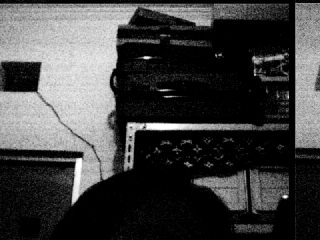

In [14]:
for __ in range(2000):
    frame = vdma.readchannel.readframe()
    clear_output(wait=True)
    img = Image.fromarray(frame, 'RGB')
    img = img.resize((320, 240))
    display(img)

In [22]:
import cv2
import numpy as np

In [ ]:
# Convert the PIL image to a NumPy array
img_array = np.array(img)

# Slice the image into 4 parts
part1 = img_array[:206, :359, :] # TL
part2 = img_array[:206, 360:, :] # TR
part3 = img_array[207:, :359, :] # BL
part4 = img_array[207:, 360:, :] # BR

# Merge the two parts with part2 on the left followed by part1
T = np.concatenate((part2, part1), axis=1)
B = np.concatenate((part4, part3), axis=1)
merged_img = np.concatenate((B,T), axis=0)

# Convert the merged image back to a PIL image
merged_img_pil = Image.fromarray(merged_img)

# Display the merged image
display(merged_img_pil)